In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import feature_manager as fma
import rl.env_simple_crypto_trade as env
import importlib
import rl.models as rla
import config as cf
import numpy as np
import torch as th
import tr_utils

In [ ]:
importlib.reload(fma)

fm = fma.FeatureManager()
fm.import_data(symbol="BTCUSDT",timeframes=["4h","1d","1w","1mo"])

fm.build_features(
    lags = [1,1,1,1],
    features=cf.DEFAULT_INDICATORS,
)

In [ ]:
importlib.reload(env)
importlib.reload(cf)

env_kwargs = cf.TRADE_ENV_PARAMETER
state_space = 10 + len(fm.cols)

full_env = env.CryptoTradingEnv(
    trade_timeframe="4h",
    df = fm.df, 
    state_space=state_space,
    indicators=fm.cols,
    **env_kwargs)

In [62]:
importlib.reload(rla)
agent = rla.DRLTradeAgent(env=full_env)

PPO_MODEL_PARAMS = {
    "n_steps": 9200,
    "ent_coef": 0.02,
    "learning_rate": 0.00025,
    "batch_size": 230
}

PPO_POLICY_PARAMS = {
    "activation_fn":th.nn.Tanh,
    "net_arch": dict(pi=[128], vf=[128])
}

catalog_name = tr_utils.get_name_with_kwargs("add_1layer128_tanh",PPO_MODEL_PARAMS)

print(catalog_name)

add_1layer128_tanh_n_steps_9200_ent_coef_0.02_learning_rate_0.00025_batch_size_230


In [63]:
timestep =1_440_000

selected_model = agent.load_model_from_checkpoint(
    "ppo",f"{catalog_name}/rl_model_{timestep}_steps")
agent.predict(
    model=selected_model,
    environment=full_env,
    render=False
)

Successfully load model from ../saved_models/checkpoint/add_1layer128_tanh_n_steps_9200_ent_coef_0.02_learning_rate_0.00025_batch_size_230/rl_model_1440000_steps


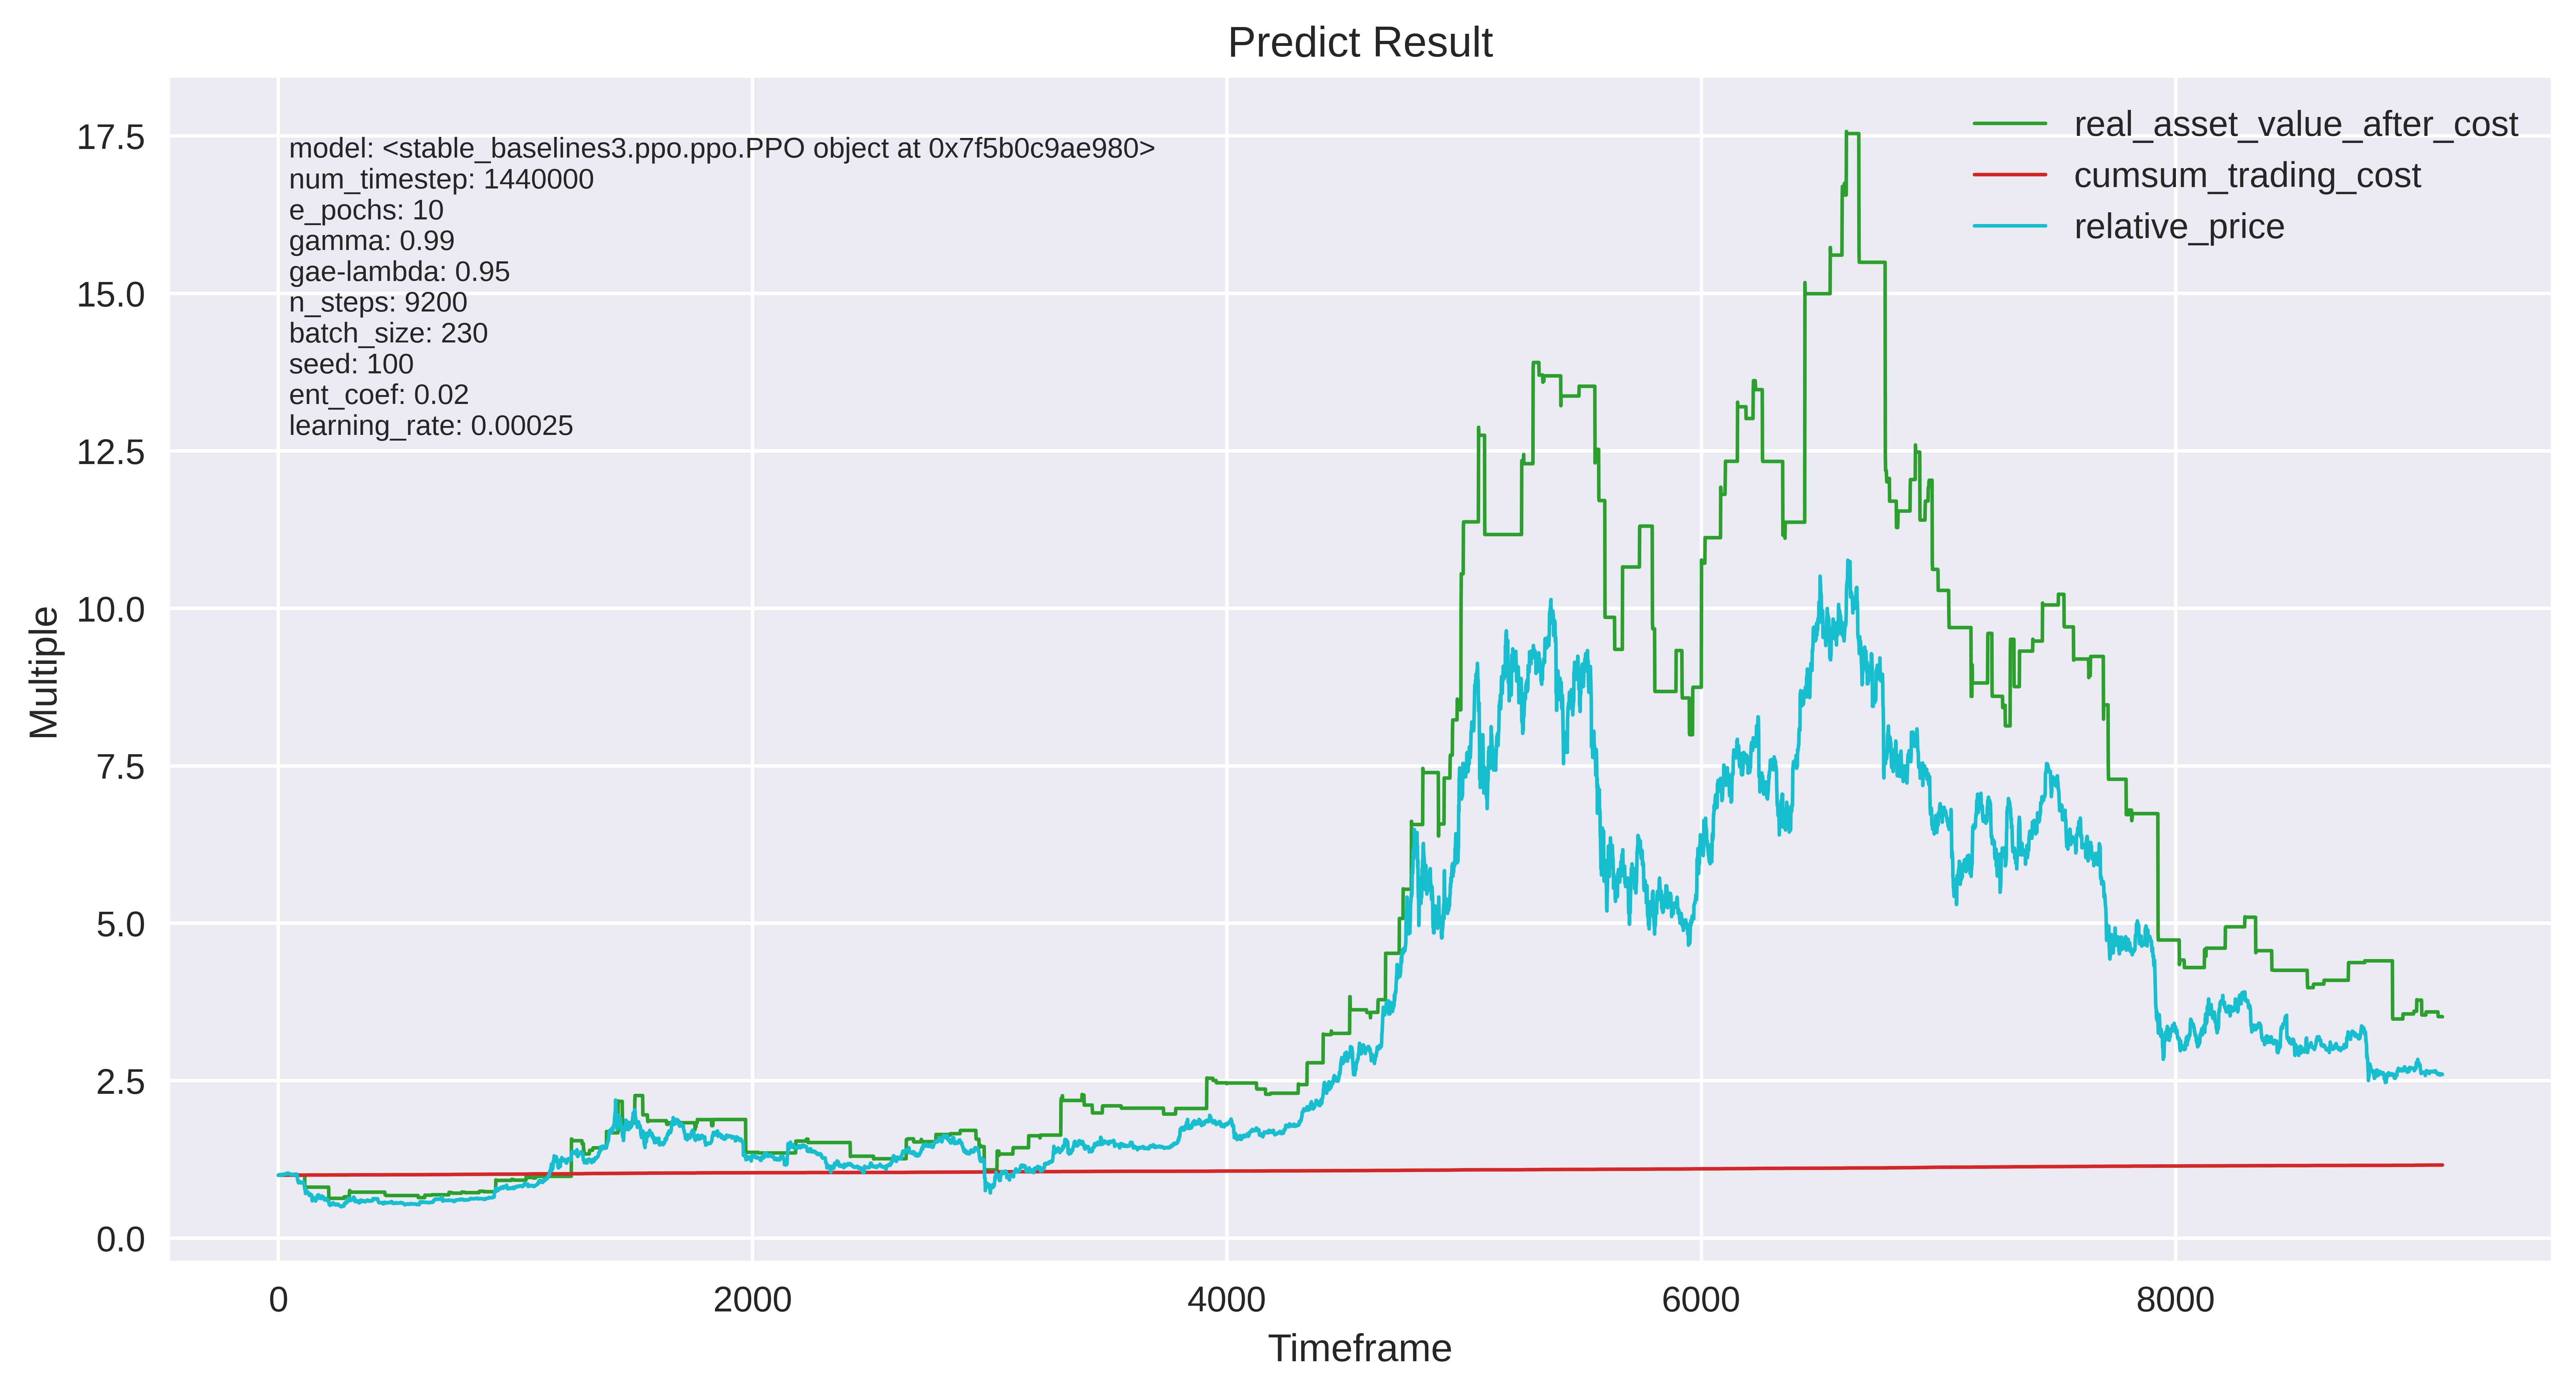

In [64]:
agent.plot_results()